In [1]:
import pandas as pd
import numpy as np
from keras import callbacks 
from nltk.stem import WordNetLemmatizer 
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, roc_curve, RocCurveDisplay, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras.optimizers import Adam
from keras import backend
from sklearn.feature_extraction import text

In [2]:
df = pd.read_csv('MoodyLyrics-1865-Sentiment-Audio.csv', index_col=0, encoding="utf-8")
#df

### Clean lyrics - remove remaining section headers and punctuations

In [3]:
contractions = {"aight": "alright",
"ain't": "am not",
"amn't": "am not",
"aren't": "are not",
"can't": "cannot",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"daren't": "dared not",
"daresn't": "dare not",
"dasn't": "dare not",
"didn't":"did not",
"doesn't":"does not",
"don't": "do not",
"dunno": "do not know",
"d'ye": "do you",
"e'er":"ever",
"'em": "them",
"everybody's":"everybody is",
"everyone's": "everyone is",
"finna": "going to",
"g'day": "good day",
"gimme":"give me",
"giv'n": "given",
"gonna": "going to",
"gon't": "go not",
"gotta":"got to",
"hadn't":"had not",
"had've":"had have",
"hasn't": "has not",
"haven't":"have not",
"he'd": "he would",
"he'll": "he will", 
"he's": "he is",
"here's": "here is",
"he've":"he have",
"how'd": "how did", 
"howdy": "how do you do",
"how'll": "how will",
"how're": "how are",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'm": "I am",
"I'm'a": "I am about to",
"I'm'o": "I am going to",
"innit": "is it not",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"iunno": "I don't know",
"kinda": "kind of",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"may've": "may have",
"methinks": "me thinks",
"mightn't": "might not",
"might've": "might have",
"mustn't": "must not",
"mustn't've": "must not have",
"must've": "must have",
"needn't":"need not",
"nal" : "and all",
"ne'er": "never",
"o'clock": "of the clock",
"o'er": "over",
"ol'": "old",
"oughtn't": "ought not",
"shan't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't" :"should not",
"shouldn't've": "should not have",
"somebody's":"somebody is",
"someone's": "someone is",
"something's": "something is",
"so're":"so are",
"that'll":"that will",
"that're": "that are",
"that's": "that is",
"that'd": "that would",
"there'd": "there would",
"there'll":"there will",
"there're": "there are",
"there's": "there has",
"these're": "these are",
"these've": "these have",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"this's": "this is",
"those're": "those are",
"those've": "those have",
"'tis": "it is",
"to've": "to have",
"'twas": "it was",
"wanna": "want to",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we're": "we are",
"we've": "we have", 
"weren't": "were not", 
"what'd": "what did",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"where'd": "where did",
"where'll": "where will",
"where're": "where are",
"where's": "where is",
"where've": "where have",
"which'd": "which would",
"which'll": "which will",
"which're": "which are",
"which's": "which is",
"which've": "which have",
"who'd": "who would",
"who'd've": "who would have",
"who'll": "who will",
"who're": "who are",
"who's": "who is",
"who've": "who have",
"why'd": "why did",
"why're": "why are",
"why's": "why is",
"willn't": "will not",
"won't": "will not",
"wonnot": "will not",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd've": "you all would have",
"y'all'd'n've": "you all would not have",
"y'all're": "you all are",
"y'at": "you at",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"you've": "you have"
               }

In [4]:
def clean_lyrics(lyrics):
    # Replace next line characters with spaces
    lyrics = lyrics.replace("\\n", " ")
    lyrics = lyrics.replace("’", "'")
    #print("Changed next line to space:\n",lyrics, "\n")
    # Remove section headers in brackets - will include adlibs and background vocals
    lyrics = re.sub("[\(\[].*?[\)\]]", "", lyrics)
    #print("Removed section headers in brackets:\n", lyrics, "\n")
    # Remove section headers and terms not in brackets
    # (1) repeat x2
    # (2) repeat 2x
    # (3) repeat 2
    headers = ["Verse", "Chorus", "Repeat", "Solo", "Bridge", "Interlude", "Instrumental"]
    for header in headers:
        lyrics = re.sub(r'(?:\b'+header+r'\b\s\dx|\b'+header+r'\b\sx\d|\b'+header+r'\b\s\d|\b'+header+r'\b\s\d\:)', "",
                        lyrics, flags=re.IGNORECASE)
        lyrics = re.sub(r'\s+?(?:\b'+header+r'\b)\s*?', "", lyrics)
    
    # Expand contractions
    word_list = lyrics.split()
    for i in range(0, len(word_list)):
        word = word_list[i].lower()
        if word in contractions.keys():
            word_list[i] = contractions[word]
            
    lyrics = ' '.join(word_list)
    
    # Remove remaining numbers
    lyrics = re.sub(r'\d+', " ", lyrics)
    
    # Remove punctuations
    punctuations = '''-;:'"\,<>.../@#$%^&*_~'''
    
    for punc in punctuations:
        lyrics = lyrics.replace(punc, " ")
    
    # Remove single letter words other than i and a
    # No lemmatizer for LSTM
    lem_lyrics = []
    list_lyrics = lyrics.split()
    for i in range(len(list_lyrics)):
        word = list_lyrics[i].lower()
        if not (len(word) == 1 and word not in ['i', 'a']):
            lem_lyrics.append(word) 
            
    # Remove any double spaces
    lyrics = ' '.join(lem_lyrics)
    
    return lyrics.lower()

df['lyrics'] = df['lyrics'].apply(clean_lyrics)

df['lyrics'].head(5)

index
ML1    in the past there were arguments for and again...
ML2    baby give me a give me a a give me a give me a...
ML3    black theatre of love violet dancers cast thei...
ML4    would you like to swing on a star carry moonbe...
ML5    heads up! heads up! here is another one! and a...
Name: lyrics, dtype: object

In [5]:
def getLen(lyrics):
    return len(lyrics.split(' '))

#getLen(df['lyrics']['ML2'])

In [6]:
df['length'] = df['lyrics'].apply(getLen)

print("Mean length:", df.length.mean())
print("Max length:", df.length.max())
print("Standard Dev. length:", df.length.std())
print("3rd Quantile length:", df.length.quantile(0.75))

Mean length: 250.71152815013406
Max length: 1129
Standard Dev. length: 150.55421008003879
3rd Quantile length: 311.0


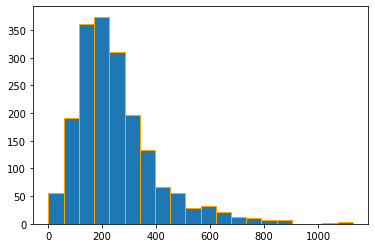

In [7]:
plt.hist(df['length'], bins=20, edgecolor='orange')
plt.show()

In [8]:
results = Counter()
df['lyrics'].str.lower().str.split().apply(results.update)
print(len(results))

17301


In [9]:
targets = pd.get_dummies(df['lyrics sentiment']).values
#targets = np.array(list(map(lambda x: 1 if x=="pos" else 0, df['lyrics sentiment'])))
targets.shape

(1865, 2)

In [10]:
lyrics = np.asarray(df['lyrics'], dtype="str")

instances_train, instances_test, target_train, target_test = train_test_split(lyrics, targets, test_size=0.2, random_state=0)

print("Train set:", instances_train.shape, "Test set:", instances_test.shape)

Train set: (1492,) Test set: (373,)


In [14]:
sequence_length = 400 # 3rd-Quantile
max_features = 20000 # Words accounted for

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<OOV>', filters=' ')
tokenizer.fit_on_texts(instances_train)

data = tokenizer.texts_to_sequences(instances_train)

data = pad_sequences(data, sequence_length)

In [15]:
embeddings = {}

embed_file = open('./Glove/glove.twitter.27B.50d.txt', 'r', encoding='utf-8')
for line in embed_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings[word] = coefs
embed_file.close()

print("Word Vectors:", len(embeddings))

Word Vectors: 1193515


In [16]:
vocab_size = tokenizer.word_index
print("Unique tokens:", len(vocab_size))

Unique tokens: 15292


In [18]:
num_words = len(vocab_size) + 1
print(num_words)

embedding_dim = 50

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

15293


In [20]:
model = Sequential()
model.add(Embedding(num_words, 
                    embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=sequence_length, 
                    trainable=False))
model.add(SpatialDropout1D(0.25))
model.add(Bidirectional(LSTM(25, return_sequences=True)))
#model.add(Bidirectional(LSTM(25, dropout=0.5)))
model.add(Bidirectional(LSTM(25, dropout=0.5, recurrent_dropout=0.5)))
#model.add(LSTM(100))
#model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(2, activation='softmax'))
#model.add(Dense(1, activation='sigmoid'))
adam = Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model.summary())
          

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           764650    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 50)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400, 50)           15200     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50)                15200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 795,152
Trainable params: 30,502
Non-trainable params: 764,650
_________________________________________________________________
None


In [76]:
batch_size = 64

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 4,  
                                        restore_best_weights = True)

analyser = model.fit(data, target_train, epochs=9, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[earlystopping])

Epoch 1/15
19/19 [==============================] - 15s 622ms/step - loss: 0.7014 - accuracy: 0.5381 - val_loss: 0.6403 - val_accuracy: 0.6555
Epoch 2/15
19/19 [==============================] - 11s 570ms/step - loss: 0.6277 - accuracy: 0.6459 - val_loss: 0.6368 - val_accuracy: 0.6355
Epoch 3/15
19/19 [==============================] - 11s 567ms/step - loss: 0.5897 - accuracy: 0.6607 - val_loss: 0.6167 - val_accuracy: 0.6555
Epoch 4/15
19/19 [==============================] - 10s 536ms/step - loss: 0.5623 - accuracy: 0.7027 - val_loss: 0.6017 - val_accuracy: 0.6957
Epoch 5/15
19/19 [==============================] - 14s 750ms/step - loss: 0.5009 - accuracy: 0.7628 - val_loss: 0.6070 - val_accuracy: 0.6522
Epoch 6/15
19/19 [==============================] - 12s 636ms/step - loss: 0.5079 - accuracy: 0.7543 - val_loss: 0.6194 - val_accuracy: 0.6589
Epoch 7/15
19/19 [==============================] - 12s 607ms/step - loss: 0.4871 - accuracy: 0.7737 - val_loss: 0.6006 - val_accuracy: 0.6923

[0.6402557492256165, 0.6367627382278442, 0.6166613698005676, 0.6016574501991272, 0.6070055961608887, 0.6194083094596863, 0.6005815267562866, 0.673003077507019, 0.59841388463974, 0.7340521812438965, 0.6434102654457092, 0.6207807064056396, 0.6569307446479797]
[0.6555184125900269, 0.6354514956474304, 0.6555184125900269, 0.695652186870575, 0.6521739363670349, 0.6588628888130188, 0.692307710647583, 0.6856187582015991, 0.6989966630935669, 0.6321070194244385, 0.6688963174819946, 0.6555184125900269, 0.6989966630935669]


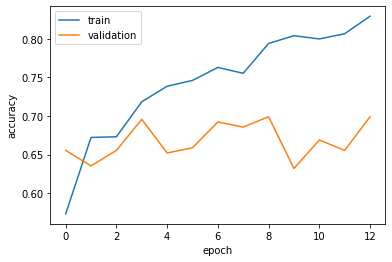

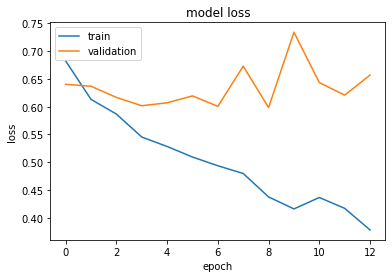

In [77]:
print(analyser.history['val_loss'])
print(analyser.history['val_accuracy'])

plt.plot(analyser.history['accuracy'])
plt.plot(analyser.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(analyser.history['loss'])
plt.plot(analyser.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [78]:
test_data = tokenizer.texts_to_sequences(instances_test)

test_data = pad_sequences(test_data, sequence_length)

In [79]:
score = model.evaluate(test_data, target_test, verbose=1, batch_size=64)
print("Test Loss:", score[0])
print("Test Accuracy", score[1])

6/6 [==============================] - 1s 140ms/step - loss: 0.6196 - accuracy: 0.6676
Test Loss: 0.6196109652519226
Test Accuracy 0.667560338973999


In [80]:
predictions = model.predict(test_data, batch_size=64) # Hold out test

In [81]:
predictions_encoded = list(np.where(np.array(predictions) > 0.5, 1, 0 )) # Convert to 0 and 1s - 2D array

In [82]:
def reverse_encode(encoded):
    labelled = []
    for row in encoded:
        if row[0] == 1:
            labelled.append('neg')
        elif row[1] == 1:
            labelled.append('pos')
    
    return labelled

In [83]:
label_predictions = reverse_encode(predictions_encoded) # Convert to labels in 1D list
label_targets = reverse_encode(target_test) # Convert targets to labels in 1D list

# Convert 1D label list to 1D encoded array
oned_predictions = np.array(list(map(lambda x: 1 if x=="pos" else 0, label_predictions))) 
# Convert 1D label target list to 1D encoded array
oned_targets = np.array(list(map(lambda x: 1 if x=="pos" else 0, label_targets)))

In [84]:
print(classification_report(label_targets, label_predictions))

              precision    recall  f1-score   support

         neg       0.70      0.77      0.73       219
         pos       0.62      0.52      0.56       154

    accuracy                           0.67       373
   macro avg       0.66      0.65      0.65       373
weighted avg       0.66      0.67      0.66       373



[[169  50]
 [ 74  80]]


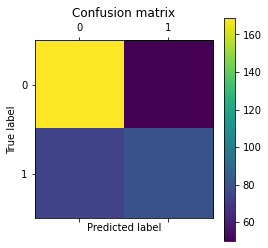

In [85]:
confusionMatrix = confusion_matrix(label_targets, label_predictions)
print(confusionMatrix)
plt.matshow(confusionMatrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(label_targets, label_predictions, output_dict=True)

harmonic_mean_acc = 1/((1/2)*((1/report['neg']['recall']) + (1/report['pos']['recall'])))

harmonic_mean_acc

In [122]:
model.save("keras_models\mdl_bilstm50D_drp.h5")

In [35]:
from tensorflow import keras

In [36]:
loaded_model = keras.models.load_model('keras_models\mdl_bilistm_rdrp.h5')

In [37]:
score = loaded_model.evaluate(test_data, target_test, verbose=1, batch_size=64)
print("Test Loss:", score[0])
print("Test Accuracy", score[1])

6/6 [==============================] - 3s 253ms/step - loss: 0.5952 - accuracy: 0.6622
Test Loss: 0.5952327847480774
Test Accuracy 0.6621983647346497


In [28]:
fpr, tpr, thresholds = roc_curve(oned_targets, oned_predictions)

In [29]:
auc_score = auc(fpr, tpr)

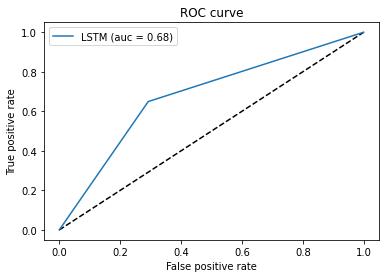

In [30]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LSTM (auc = {:.2f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### K-Fold Cross Validation

In [123]:
def get_model():
    model = Sequential()
    model.add(Embedding(num_words, 
                            embedding_dim, 
                            embeddings_initializer=Constant(embedding_matrix), 
                            input_length=sequence_length, 
                            trainable=False))
    model.add(SpatialDropout1D(0.25))
    model.add(Bidirectional(LSTM(25, return_sequences=True)))
    model.add(Bidirectional(LSTM(25, dropout=0.5)))
    #model.add(Bidirectional(LSTM(25, dropout=0.5, recurrent_dropout=0.5)))
    #model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
    #model.add(LSTM(100, dropout=0.5))
    model.add(Dense(2, activation='softmax'))
    adam = Adam(learning_rate=0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
    
    return model

In [124]:
kcv_accuracy = []
batch_size = 64

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 4,  
                                        restore_best_weights = True)

def kfold_cv(kfolds, train_data, train_labels):
    kf = StratifiedKFold(n_splits=kfolds)
    kf.get_n_splits(train_data, train_labels)
    kcv_train_indexes = []
    kcv_test_indexes = []
    
    recoded_train_labels = reverse_encode(train_labels)
    oned_train_labels = np.array(list(map(lambda x: 1 if x=="pos" else 0, recoded_train_labels)))
    
    for train_idx, test_idx in kf.split(train_data, oned_train_labels):
        kcv_train_indexes.append(train_idx)
        kcv_test_indexes.append(test_idx)
        
    for i in range(kfolds):
        print("Fold-{}".format(i+1))
        cvmodel = get_model()
        kcv_train, kcv_train_labels = train_data[kcv_train_indexes[i]], train_labels[kcv_train_indexes[i]]
        kcv_test, kcv_test_labels = train_data[kcv_test_indexes[i]], train_labels[kcv_test_indexes[i]]
        history = cvmodel.fit(kcv_train, kcv_train_labels, epochs=9, batch_size=batch_size, verbose=1, 
                              validation_data=(kcv_test, kcv_test_labels), callbacks=[earlystopping])
        min_loss = min(history.history['val_loss'])
        min_loss_idx = history.history['val_loss'].index(min_loss)
        kcv_accuracy.append(history.history['val_accuracy'][min_loss_idx])
        backend.clear_session()
    
    kcv_score = 0.0
    for res in kcv_accuracy:
        kcv_score += res
    kcv_score = kcv_score / len(kcv_accuracy)
    
    return kcv_score
    
#kfold_cv(10, data, target_train)
kfold_score = kfold_cv(10, data, target_train)
print("10-Fold Accuracy: {} %".format(kfold_score))

Fold-1
Epoch 1/9
21/21 [==============================] - 28s 822ms/step - loss: 0.6818 - accuracy: 0.5833 - val_loss: 0.6509 - val_accuracy: 0.6267
Epoch 2/9
21/21 [==============================] - 15s 702ms/step - loss: 0.6584 - accuracy: 0.6108 - val_loss: 0.6315 - val_accuracy: 0.6733
Epoch 3/9
21/21 [==============================] - 16s 748ms/step - loss: 0.6461 - accuracy: 0.6327 - val_loss: 0.6251 - val_accuracy: 0.6800
Epoch 4/9
21/21 [==============================] - 17s 802ms/step - loss: 0.6545 - accuracy: 0.5993 - val_loss: 0.6297 - val_accuracy: 0.6600
Epoch 5/9
21/21 [==============================] - 16s 755ms/step - loss: 0.6227 - accuracy: 0.6419 - val_loss: 0.6212 - val_accuracy: 0.6467
Epoch 6/9
21/21 [==============================] - 15s 737ms/step - loss: 0.6295 - accuracy: 0.6344 - val_loss: 0.6194 - val_accuracy: 0.6933
Epoch 7/9
21/21 [==============================] - 16s 749ms/step - loss: 0.6132 - accuracy: 0.6657 - val_loss: 0.6177 - val_accuracy: 0.6733

In [74]:
backend.clear_session()